# Employee Data Analysis

**Introduction:**
This project aims to analyze employee data using PySpark, a powerful analytics engine for big data processing. The dataset consists of information about employees, including their names, departments, salaries, and joining dates. The project involves data cleaning, deduplication, analysis, and visualization to gain insights into employee demographics and trends.

In [2]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, row_number, avg, when, to_date
from pyspark.sql.window import Window

In [3]:
# Initialize Spark session
spark = SparkSession.builder.appName('Employee_Analysis').getOrCreate()

In [4]:
# Read the Employee and Department tables into DataFrames
employee_df = spark.read.csv('Datasets/Employee.csv', header=True, inferSchema=True)
department_df = spark.read.csv('Datasets/Department.csv', header=True, inferSchema=True)

In [5]:
# View top rows from tables
employee_df.show(5)
department_df.show(5)

+----------+---------+--------+------------+------+-----------+
|EmployeeID|FirstName|LastName|DepartmentID|Salary|JoiningDate|
+----------+---------+--------+------------+------+-----------+
|         1|     John|     Doe|         101| 60000|  1/15/2022|
|         2|    Alice|   Smith|         102| 65000|  2/20/2022|
|         3|  Michael| Johnson|         101| 58000|  3/10/2022|
|         4|    Emily|   Brown|         103| 70000|   4/5/2022|
|         5|    David|     Lee|         102| 62000|  5/12/2022|
+----------+---------+--------+------------+------+-----------+
only showing top 5 rows

+------------+--------------+---------+
|DepartmentID|DepartmentName|ManagerID|
+------------+--------------+---------+
|         101|         Sales|        1|
|         102|     Marketing|        2|
|         103|       Finance|        4|
|         104|            HR|     NULL|
|         105|    Operations|        7|
+------------+--------------+---------+
only showing top 5 rows



In [6]:
# Register the DataFrames as temporary views
employee_df.createOrReplaceTempView("employee_table")
department_df.createOrReplaceTempView("department_table")

## Data Preprocessing

The data preprocessing steps include handling duplicates, missing values, and standardizing data.

1. **Handling Duplicates**: 
    - Duplicates in the employee table are checked and removed.
2. **Handling Missing Values**: 
    - Missing values in the DataFrame are replaced or dropped.
3. **Standardizing Data**: 
    - String columns are converted to lowercase with the first letter capitalized.

In [8]:
# Check for duplicate records in the employee table
duplicate_records_df = spark.sql("""
    SELECT EmployeeID, FirstName, LastName, DepartmentID, Salary, JoiningDate, COUNT(*) AS duplicate_count
    FROM employee_table
    GROUP BY EmployeeID, FirstName, LastName, DepartmentID, Salary, JoiningDate
    HAVING COUNT(*) > 1
""")

# Show the duplicate records
duplicate_records_df.show()

+----------+---------+----------+------------+------+-----------+---------------+
|EmployeeID|FirstName|  LastName|DepartmentID|Salary|JoiningDate|duplicate_count|
+----------+---------+----------+------------+------+-----------+---------------+
|         3|  Michael|   Johnson|         101| 58000|       NULL|              2|
|        22|    Megan|     Scott|         101| 63000| 10/10/2023|              3|
|        19|    Kevin|     White|         102| 68000|  7/25/2023|              3|
|         9|   Robert|    Taylor|         104| 68000|   9/5/2022|              3|
|        34|   Hannah|   Collins|         101| 66000| 10/10/2024|              3|
|        28|   Alexis|    Turner|         103| 76000|  4/10/2024|              3|
|        23|  Brandon|     Green|         102| 69000| 11/15/2023|              3|
|        38| Danielle|    Howard|         101| 67000|       NULL|              2|
|        44|    Sarah|    Barnes|         103| 80000|  8/30/2025|              3|
|        30|   O

In [9]:
# Count the number of rows in the DataFrame
row_count = duplicate_records_df.count()

# Print the row count
print("Number of Rows:", row_count)


Number of Rows: 48


In [10]:
# Remove duplicates from the employee DataFrame
cleaned_employee_df = employee_df.dropDuplicates(['EmployeeID', 'FirstName', 'LastName', 'DepartmentID', 'JoiningDate'])

In [11]:
# Register the cleaned DataFrame as a temporary view
cleaned_employee_df.createOrReplaceTempView("cleaned_employee_view")

In [12]:
# Check for duplicates in the cleaned DataFrame
duplicates_still_exist_df = spark.sql("""
    SELECT FirstName, LastName, DepartmentID, JoiningDate, COUNT(*) AS duplicate_count
    FROM cleaned_employee_view
    GROUP BY FirstName, LastName, DepartmentID, JoiningDate
    HAVING COUNT(*) > 1
""")

# Show any remaining duplicates
duplicates_still_exist_df.show()

+---------+--------+------------+-----------+---------------+
|FirstName|LastName|DepartmentID|JoiningDate|duplicate_count|
+---------+--------+------------+-----------+---------------+
|  William|   Kelly|         102|   3/5/2025|              3|
|  Zachary|  Parker|         102|  7/25/2024|              3|
+---------+--------+------------+-----------+---------------+



In [13]:
# We still have duplicates with the firstNames William and Zachary, so check which columns have duplicate values for these two employees

# Check for duplicates in the cleaned DataFrame
duplicates_still_exist_df = spark.sql("""
    SELECT *
    FROM cleaned_employee_view
    Where FirstName LIKE '%William%' OR FirstName LIKE '%Zachary%'
""")

# Show any remaining duplicates
duplicates_still_exist_df.show()

+----------+---------+--------+------------+------+-----------+
|EmployeeID|FirstName|LastName|DepartmentID|Salary|JoiningDate|
+----------+---------+--------+------------+------+-----------+
|        39|  William|   Kelly|         102| 73000|   3/5/2025|
|        89|  William|   Kelly|         102| 73000|   3/5/2025|
|       139|  William|   Kelly|         102| 73000|   3/5/2025|
|        31|  Zachary|  Parker|         102| 71000|  7/25/2024|
|        81|  Zachary|  Parker|         102| 71000|  7/25/2024|
|       131|  Zachary|  Parker|         102| 71000|  7/25/2024|
+----------+---------+--------+------------+------+-----------+



In [14]:
# As we can see these employees have different employee ids, we will keep the row with lowest employeeID and remove the remaining rows.

# Define a window specification partitioned by FirstName and LastName and ordered by EmployeeID
window_spec = Window.partitionBy("FirstName", "LastName").orderBy("EmployeeID")

# Add a row number column to each row based on the window specification
cleaned_employee_df = cleaned_employee_df.withColumn("row_number", row_number().over(window_spec))

# Keep only the rows with row_number = 1, which corresponds to the lowest EmployeeID for each unique FirstName and LastName combination
deduplicated_employee_df = cleaned_employee_df.filter("row_number = 1").drop("row_number")

# Show the deduplicated DataFrame
deduplicated_employee_df.show(50)

+----------+-----------+----------+------------+------+-----------+
|EmployeeID|  FirstName|  LastName|DepartmentID|Salary|JoiningDate|
+----------+-----------+----------+------------+------+-----------+
|        49|       Adam|    Cooper|         104| 78000|  1/25/2026|
|        28|     Alexis|    Turner|         103| 76000|  4/10/2024|
|         2|      Alice|     Smith|         102| 65000|  2/20/2022|
|        16|     Amanda|  Anderson|         103| 73000|  4/10/2023|
|        33|     Andrew|   Edwards|         104| 74000|   9/5/2024|
|        14|     Ashley|     Lopez|         101| 61000|  2/28/2023|
|        29|   Benjamin|  Phillips|         104| 73000|  5/15/2024|
|        23|    Brandon|     Green|         102| 69000| 11/15/2023|
|        17|      Brian|     Moore|         104| 70000|  5/15/2023|
|        13|Christopher| Hernandez|         104|  NULL|  1/25/2023|
|        11|     Daniel|  Anderson|         102| 66000| 11/15/2022|
|        38|   Danielle|    Howard|         101|

In [15]:
# Register the cleaned DataFrame as a temporary view
deduplicated_employee_df.createOrReplaceTempView("deduplicated_employee_view")

In [16]:
# Check for duplicates in the cleaned DataFrame where FirstName contains 'William' or 'Zachary'
duplicates_check_df = spark.sql("""
    SELECT FirstName, LastName, DepartmentID, Salary, JoiningDate, COUNT(*) AS duplicate_count
    FROM deduplicated_employee_view
    GROUP BY FirstName, LastName, DepartmentID, Salary, JoiningDate
    HAVING COUNT(*) > 1
""")

# Show any remaining duplicates
duplicates_check_df.show()

+---------+--------+------------+------+-----------+---------------+
|FirstName|LastName|DepartmentID|Salary|JoiningDate|duplicate_count|
+---------+--------+------------+------+-----------+---------------+
+---------+--------+------------+------+-----------+---------------+



In [17]:
# Check for duplicates in the cleaned DataFrame where FirstName contains 'William' or 'Zachary'
duplicated_employee_df = spark.sql("""
    SELECT *
    FROM deduplicated_employee_view
    Where FirstName LIKE '%William%' OR FirstName LIKE '%Zachary%'                                 
""")

# Show any remaining duplicates
duplicated_employee_df.show()

+----------+---------+--------+------------+------+-----------+
|EmployeeID|FirstName|LastName|DepartmentID|Salary|JoiningDate|
+----------+---------+--------+------------+------+-----------+
|        39|  William|   Kelly|         102| 73000|   3/5/2025|
|        31|  Zachary|  Parker|         102| 71000|  7/25/2024|
+----------+---------+--------+------------+------+-----------+



In [18]:
# Check for Null values in any of the column
null_employee_df = spark.sql("""
    SELECT *
    FROM deduplicated_employee_view
    Where EmployeeID='NULL' or FirstName ='NULL' or LastName ='NULL' or DepartmentID='NULL' or Salary='NULL' or JoiningDate ='NULL'
""")

# Show any remaining duplicates
null_employee_df.show()

+----------+-----------+----------+------------+------+-----------+
|EmployeeID|  FirstName|  LastName|DepartmentID|Salary|JoiningDate|
+----------+-----------+----------+------------+------+-----------+
|        13|Christopher| Hernandez|         104|  NULL|  1/25/2023|
|        42|      Kayla|    Murphy|         101|  NULL|  6/20/2025|
|        48|      Laura|    Brooks|         103| 81000|       NULL|
|        52|     Lauren|      NULL|         101| 65000|  2/20/2022|
|        15|    Matthew|    Wilson|         102| 67000|       NULL|
|        51|       NULL|    Parker|         105| 60000|  1/15/2022|
|        43|    Timothy|Richardson|         102| 74000|       NULL|
+----------+-----------+----------+------------+------+-----------+



In [19]:
# Calculate the average salary excluding null values
avg_salary = deduplicated_employee_df.select(avg("Salary")).collect()[0][0]

# Replace null values in Salary column with average salary
deduplicated_employee_df = deduplicated_employee_df.withColumn("Salary", when(col("Salary").isNull(), avg_salary).otherwise(col("Salary")))


# Show any remaining duplicates
deduplicated_employee_df.show()


+----------+-----------+---------+------------+------+-----------+
|EmployeeID|  FirstName| LastName|DepartmentID|Salary|JoiningDate|
+----------+-----------+---------+------------+------+-----------+
|        49|       Adam|   Cooper|         104| 78000|  1/25/2026|
|        28|     Alexis|   Turner|         103| 76000|  4/10/2024|
|         2|      Alice|    Smith|         102| 65000|  2/20/2022|
|        16|     Amanda| Anderson|         103| 73000|  4/10/2023|
|        33|     Andrew|  Edwards|         104| 74000|   9/5/2024|
|        14|     Ashley|    Lopez|         101| 61000|  2/28/2023|
|        29|   Benjamin| Phillips|         104| 73000|  5/15/2024|
|        23|    Brandon|    Green|         102| 69000| 11/15/2023|
|        17|      Brian|    Moore|         104| 70000|  5/15/2023|
|        13|Christopher|Hernandez|         104|  NULL|  1/25/2023|
|        11|     Daniel| Anderson|         102| 66000| 11/15/2022|
|        38|   Danielle|   Howard|         101| 67000|  2/28/2

In [20]:
# Check for null values in the Salary column
deduplicated_employee_df.filter(col("Salary").isNull()).show()


+----------+---------+--------+------------+------+-----------+
|EmployeeID|FirstName|LastName|DepartmentID|Salary|JoiningDate|
+----------+---------+--------+------------+------+-----------+
+----------+---------+--------+------------+------+-----------+



In [21]:
deduplicated_employee_df.printSchema()

root
 |-- EmployeeID: integer (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- DepartmentID: integer (nullable = true)
 |-- Salary: string (nullable = true)
 |-- JoiningDate: string (nullable = true)



In [22]:
from pyspark.sql.types import IntegerType

# Convert Salary column to IntegerType
deduplicated_employee_df = deduplicated_employee_df.withColumn("Salary", deduplicated_employee_df["Salary"].cast(IntegerType()))

# Calculate the average salary
avg_salary = deduplicated_employee_df.select(avg("Salary")).collect()[0][0]

# Replace null values in Salary column with average salary
deduplicated_employee_df = deduplicated_employee_df.withColumn("Salary", when(col("Salary").isNull(), avg_salary).otherwise(col("Salary")))

# Remove rows where JoiningDate is null
deduplicated_employee_df = deduplicated_employee_df.filter(col("JoiningDate").isNotNull())

# Show the updated DataFrame
deduplicated_employee_df.show()


+----------+-----------+---------+------------+-------+-----------+
|EmployeeID|  FirstName| LastName|DepartmentID| Salary|JoiningDate|
+----------+-----------+---------+------------+-------+-----------+
|        49|       Adam|   Cooper|         104|78000.0|  1/25/2026|
|        28|     Alexis|   Turner|         103|76000.0|  4/10/2024|
|         2|      Alice|    Smith|         102|65000.0|  2/20/2022|
|        16|     Amanda| Anderson|         103|73000.0|  4/10/2023|
|        33|     Andrew|  Edwards|         104|74000.0|   9/5/2024|
|        14|     Ashley|    Lopez|         101|61000.0|  2/28/2023|
|        29|   Benjamin| Phillips|         104|73000.0|  5/15/2024|
|        23|    Brandon|    Green|         102|69000.0| 11/15/2023|
|        17|      Brian|    Moore|         104|70000.0|  5/15/2023|
|        13|Christopher|Hernandez|         104|69680.0|  1/25/2023|
|        11|     Daniel| Anderson|         102|66000.0| 11/15/2022|
|        38|   Danielle|   Howard|         101|6

In [23]:
# Join the deduplicated_employee_df DataFrame with the department_df DataFrame
joined_df = deduplicated_employee_df.join(department_df, on='DepartmentID', how='left')

# Show the joined DataFrame
joined_df.show()


+------------+----------+-----------+---------+-------+-----------+--------------+---------+
|DepartmentID|EmployeeID|  FirstName| LastName| Salary|JoiningDate|DepartmentName|ManagerID|
+------------+----------+-----------+---------+-------+-----------+--------------+---------+
|         104|        49|       Adam|   Cooper|78000.0|  1/25/2026|            HR|     NULL|
|         103|        28|     Alexis|   Turner|76000.0|  4/10/2024|       Finance|        4|
|         102|         2|      Alice|    Smith|65000.0|  2/20/2022|     Marketing|        2|
|         103|        16|     Amanda| Anderson|73000.0|  4/10/2023|       Finance|        4|
|         104|        33|     Andrew|  Edwards|74000.0|   9/5/2024|            HR|     NULL|
|         101|        14|     Ashley|    Lopez|61000.0|  2/28/2023|         Sales|        1|
|         104|        29|   Benjamin| Phillips|73000.0|  5/15/2024|            HR|     NULL|
|         102|        23|    Brandon|    Green|69000.0| 11/15/2023|   

## Data Analysis

Now, let's do some basic analysis and create some graphs:


In [24]:
# import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

1. **Salary Distribution by Department**: 
    - We'll create a boxplot to visualize the distribution of salaries across different departments.

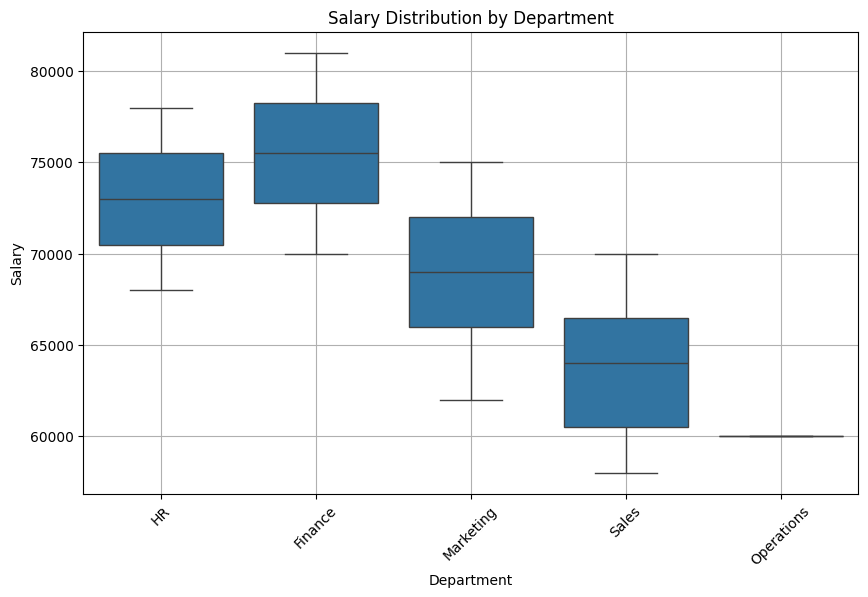

In [25]:
# Boxplot for salary distribution by department
plt.figure(figsize=(10, 6))
sns.boxplot(x='DepartmentName', y='Salary', data=joined_df.toPandas())
plt.title('Salary Distribution by Department')
plt.xlabel('Department')
plt.ylabel('Salary')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


This boxplot visualizes the distribution of salaries across different departments. Each box represents the salary distribution within a specific department. The horizontal line inside each box represents the median salary, while the box itself represents the interquartile range (IQR), with the upper and lower boundaries of the box representing the 75th and 25th percentiles, respectively. The whiskers extend to the minimum and maximum salaries within 1.5 times the IQR from the first and third quartiles, respectively. Any points beyond the whiskers are considered outliers.

2. **Average Salary by Department**: 
    - We'll calculate the average salary for each department and create a bar plot to visualize it..

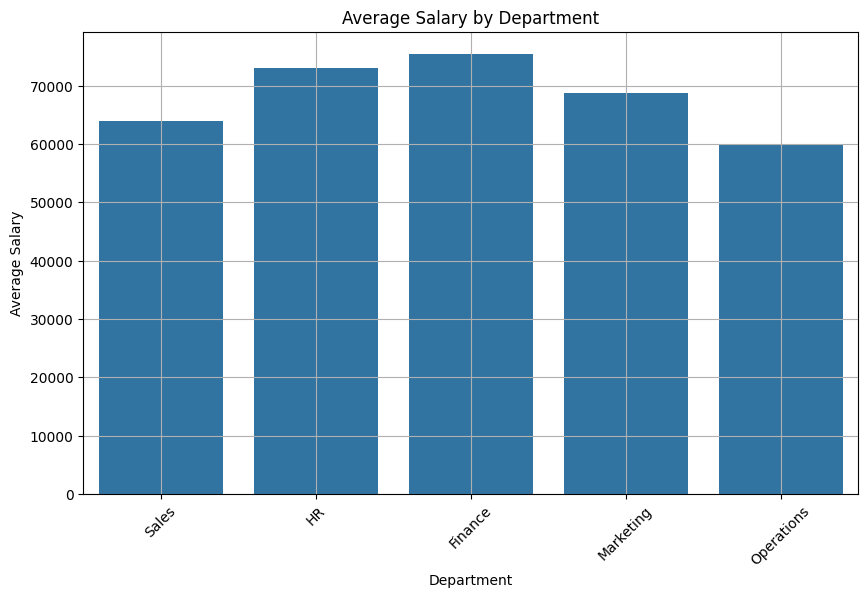

In [27]:
# Calculate average salary by department
avg_salary_by_department = joined_df.groupBy('DepartmentName').agg(avg('Salary').alias('AverageSalary'))

# Convert to Pandas DataFrame for plotting
avg_salary_by_department_df = avg_salary_by_department.toPandas()

# Bar plot for average salary by department
plt.figure(figsize=(10, 6))
sns.barplot(x='DepartmentName', y='AverageSalary', data=avg_salary_by_department_df)
plt.title('Average Salary by Department')
plt.xlabel('Department')
plt.ylabel('Average Salary')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


This bar plot displays the average salary for each department. Each bar represents a department, and the height of the bar corresponds to the average salary of employees within that department. It provides a comparison of the average salary levels across different departments.

3. **Employee Count by Department**: 
    - We'll count the number of employees in each department and create a bar plot.

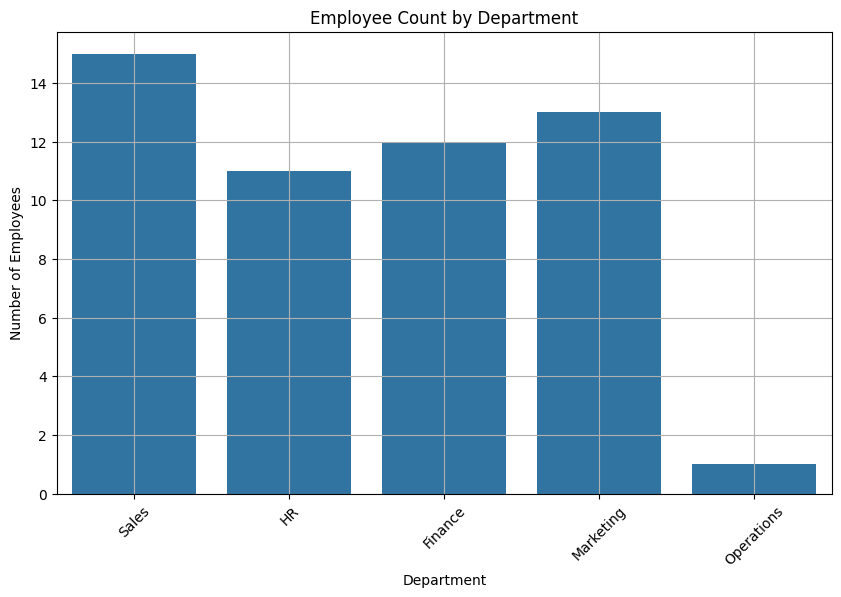

In [28]:
# Count employee by department
employee_count_by_department = joined_df.groupBy('DepartmentName').count()

# Bar plot for employee count by department
plt.figure(figsize=(10, 6))
sns.barplot(x='DepartmentName', y='count', data=employee_count_by_department.toPandas())
plt.title('Employee Count by Department')
plt.xlabel('Department')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

This bar plot illustrates the number of employees in each department. Each bar represents a department, and the height of the bar indicates the total count of employees within that department. It helps to understand the distribution of workforce among different departments.

4. **Employee Count by Manager**: 
    - We'll count the number of employees managed by each manager and create a bar plot.

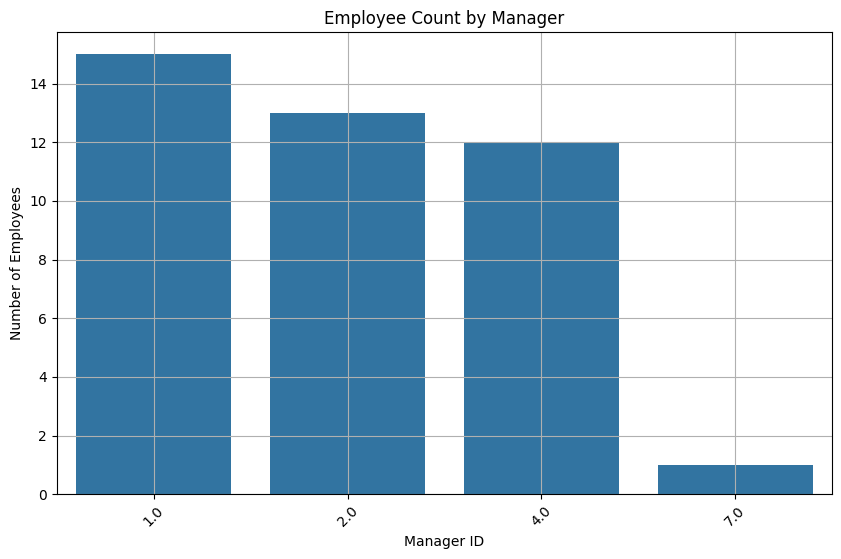

In [30]:
# Count employee by manager
employee_count_by_manager = joined_df.groupBy('ManagerID').count()

# Convert ManagerID to integers
employee_count_by_manager = employee_count_by_manager.withColumn("ManagerID", employee_count_by_manager["ManagerID"].cast(IntegerType()))

# Bar plot for employee count by manager
plt.figure(figsize=(10, 6))
sns.barplot(x='ManagerID', y='count', data=employee_count_by_manager.toPandas())
plt.title('Employee Count by Manager')
plt.xlabel('Manager ID')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


This bar plot shows the number of employees managed by each manager. Each bar represents a manager (identified by ManagerID), and the height of the bar represents the count of employees under their management. It provides insights into the workload distribution among managers.

5. **Salary Distribution**: 
    - We'll create a histogram to visualize the distribution of salaries across all employees.

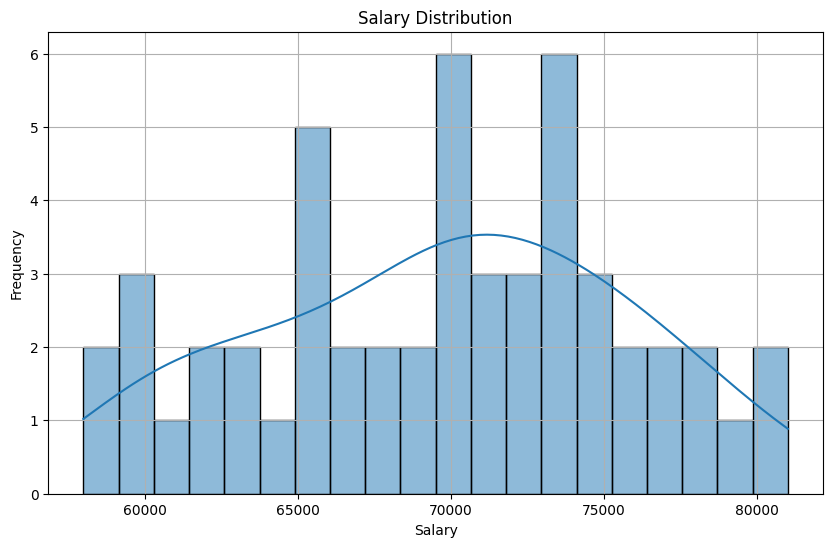

In [31]:
# Histogram for salary distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=joined_df.toPandas(), x='Salary', bins=20, kde=True)
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


This histogram displays the distribution of salaries across all employees. The x-axis represents salary ranges, while the y-axis represents the frequency of employees within each salary range. It provides an overview of the salary distribution pattern within the organization.